In [1]:
%load_ext autoreload
%autoreload 2
# Set HuggingFace cache directory to scratch to save space.
import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/' + os.environ['USER'] + '/huggingface_cache'
CACHE_DIR = '/scratch/' + os.environ['USER'] + '/huggingface_cache'
# Optional; can help when memory is tight.
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

### Load HellaSwag Dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("Rowan/hellaswag", "en-US", split="train", cache_dir=CACHE_DIR)

import numpy as np

selected_indices = np.random.choice(len(dataset["ctx"]), 5, replace=False)
selected_prompts = [dataset["ctx"][i] for i in selected_indices]

selected_prompts

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True).to('cuda')
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
from IPython.display import display, HTML, Markdown

def generate(model, tokenizer, prompt, do_display=True, max_new_tokens=50):
    input_string = prompt
    inputs = tokenizer(input_string, return_tensors="pt", return_attention_mask=True).to('cuda')
    
    outputs = model.generate(**inputs, max_new_tokens=max_new_tokens, temperature=0)
    text = tokenizer.batch_decode(outputs)[0][len(input_string):]

    if do_display:
        display(HTML(f"<pre>{input_string}</pre><pre style='background-color: rgb(200, 255, 200, 1.0)'>{text}<pre>"))

    return inputs['input_ids'][0], outputs[0], text

def run_coding_sample(model, tokenizer, display=True):
    prompt = '''def print_prime(n):
       """
       Print all primes between 1 and n
       """'''
    return generate(model, tokenizer, prompt, display)

def run_coding_sample_2(model, tokenizer):
    prompt = '''def array_sum(array, nrows, ncols):
       """
       Use two for loops to add elements of an array.
       """'''
    return generate(model, tokenizer, prompt)

In [62]:
from attribution import get_difference_gradient, search_neuron_buckets

T = lambda t: tokenizer(t, return_tensors='pt').input_ids.to('cuda')

triplets = [
    # prefix, good, bad
    ("Michael Jordan plays", " basketball", " golf"),
    ("Kobe Bryant played", " basketball", " baseball"),
    ("In many countries, what Americans call soccer is often called", " football", " cricket")
]

model.requires_grad_(False)

gradients = torch.zeros((32, 10240), device='cuda')

for prefix, expected, measured in triplets:
    difference_gradient = get_difference_gradient(model, T(prefix), T(expected), T(measured))
    for i in range(32):
        gradients[i] += difference_gradient[i].mean(dim=(0, 1))

gradients /= len(triplets)

defls = []
for layer_id in range(32):
    print("Running layer", layer_id)
    defls.append(search_neuron_buckets(model, layer_id, 128, T(prefix + expected), 1, 4))


Running layer 0
Sampling stage 0
Sampling stage 1
Sampling stage 2
Sampling stage 3
Running layer 1
Sampling stage 0
Sampling stage 1
Sampling stage 2
Sampling stage 3
Running layer 2
Sampling stage 0
Sampling stage 1
Sampling stage 2
Sampling stage 3
Running layer 3
Sampling stage 0
Sampling stage 1
Sampling stage 2
Sampling stage 3
Running layer 4
Sampling stage 0
Sampling stage 1
Sampling stage 2
Sampling stage 3
Running layer 5
Sampling stage 0
Sampling stage 1
Sampling stage 2
Sampling stage 3
Running layer 6
Sampling stage 0
Sampling stage 1
Sampling stage 2
Sampling stage 3
Running layer 7
Sampling stage 0
Sampling stage 1
Sampling stage 2
Sampling stage 3
Running layer 8
Sampling stage 0
Sampling stage 1
Sampling stage 2
Sampling stage 3
Running layer 9
Sampling stage 0
Sampling stage 1
Sampling stage 2
Sampling stage 3
Running layer 10
Sampling stage 0
Sampling stage 1
Sampling stage 2
Sampling stage 3
Running layer 11
Sampling stage 0
Sampling stage 1
Sampling stage 2
Samplin

In [87]:
from attribution import search_neuron_buckets_bucketified

defls_23_gridsearched = search_neuron_buckets_bucketified(model, 23, 128, T(prefix + expected), 1)

In [69]:
with open("acts_23.txt") as f:
    acts_23 = torch.tensor([float(x) for x in f.read().split()])

In [78]:
# plt.hist(acts_23.detach().cpu().log().numpy())
# plt.show()
order = acts_23.argsort()
acts_23[order[:15]]

tensor([-0.1070, -0.0880, -0.0610, -0.0530, -0.0280, -0.0260, -0.0250, -0.0240,
        -0.0180, -0.0180, -0.0170, -0.0170, -0.0170, -0.0160, -0.0160])

In [88]:
# acts_23_ours = defls[23]
acts_23_ours = defls_23_gridsearched
acts_23_ours[order[:15]]

tensor([ 1.6727e-02, -1.9837e-03,  7.9693e-03,  1.1566e-02,  2.7529e-02,
        -8.5924e-03, -7.1694e-03, -5.5150e-03, -6.9728e-04, -1.0110e-02,
         5.2354e-03, -9.0906e-03,  3.3131e-03, -7.2932e-03, -7.4208e-05],
       device='cuda:0')

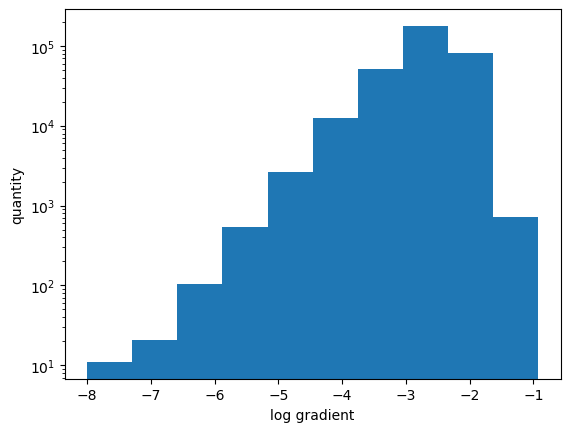

In [40]:
import matplotlib.pyplot as plt

plt.hist((1e-8 + gradients.view(-1).detach().cpu().abs()).log10())
plt.yscale("log")
plt.ylabel("quantity")
plt.xlabel("log gradient")
plt.show()


In [54]:
from hooked_phi import attach_hooks, detach_hooks

all_results = []
all_results_tokenized = []

# Returns a hook that can be used to ablate a set of neurons.
def ablate_neurons(mask):
    assert mask.shape[0] == model.config.num_hidden_layers
    assert mask.shape[1] == model.config.intermediate_size

    def hook(neurons, layer_idx):
        neurons[..., ~mask[layer_idx]] = 0
        return neurons

    return hook

# Ablate the last layer MLP.
for (start_layer, end_layer) in [(25, 26), (28, 29)]:
    display(Markdown(f'## Ablating MLPs {start_layer} to {end_layer}'))
    
    mask = torch.ones((model.config.num_hidden_layers, model.config.intermediate_size), dtype=torch.bool)
    mask[start_layer:end_layer, :] = False
    
    attach_hooks(model.model, ablate_neurons(mask))
    
    # input_ids, input_and_completion_ids, result = run_coding_sample(model, tokenizer)
    input_ids, input_and_completion_ids, result = generate(model, tokenizer, "Instruct: Who was the first United States president?\n\nOutput: Their name was", do_display=True)

    all_results.append(result)

detach_hooks(model.model)

## Ablating MLPs 25 to 26

/sfs/weka/scratch/gsk6me/WORLDMODELS/rvt/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


## Ablating MLPs 28 to 29

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [7]:
from evaluator import perplexity_evaluator

perplexity_result = perplexity_evaluator(preds=all_results)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


# Evaluate with HellaSwag

In [11]:
from evaluator import charcut_evaluator

ground_truths = []
predictions = {}

for prompt in selected_prompts:
    
    # Ablate the last layer MLP.
    for num_ablation_layers in range(0, 5, 2):
        
        mask = torch.ones((model.config.num_hidden_layers, model.config.intermediate_size), dtype=torch.bool)
        if num_ablation_layers > 0:
            mask[-num_ablation_layers:, :] = False
        
        attach_hooks(model.model, ablate_neurons(mask))
        
        input_ids, input_and_completion_ids, result = generate(model, tokenizer, prompt, do_display=False)
        
        if num_ablation_layers == 0:
            ground_truths.append(prompt+result)
        
        if num_ablation_layers not in predictions:
            predictions[num_ablation_layers] = []
        
        predictions[num_ablation_layers].append(prompt+result)
        

    detach_hooks(model.model)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

['A text intro leads into a picture of a dog and the same dog running along the yard. the dog is running with a ball in its mouth. the dog is running towards a person. the person is smiling and waving at the dog. the text says "Meet Max, the best dog in the world. He loves to play fetch and make new friends', '[header] How to overcome fear of disease [title] Work with a therapist. [step] Therapy is generally considered one of the most effective ways to manage anxiety disorders, and illness anxiety disorder is no different. There are many different approaches to therapy. [substeps] Cognitive behavioral therapy (CBT) is a common approach that helps people identify and change negative thought patterns. Exposure therapy is another approach that involves gradually exposing people to their fears in a safe and controlled environment. [substeps] Med', '[header] How to respond to passive aggressive comments [title] Avoid reacting defensively. [step] When someone makes a passive aggressive comme

In [15]:
print(ground_truths)

['A text intro leads into a picture of a dog and the same dog running along the yard. the dog is running with a ball in its mouth. the dog is running towards a person. the person is smiling and waving at the dog. the text says "Meet Max, the best dog in the world. He loves to play fetch and make new friends', '[header] How to overcome fear of disease [title] Work with a therapist. [step] Therapy is generally considered one of the most effective ways to manage anxiety disorders, and illness anxiety disorder is no different. There are many different approaches to therapy. [substeps] Cognitive behavioral therapy (CBT) is a common approach that helps people identify and change negative thought patterns. Exposure therapy is another approach that involves gradually exposing people to their fears in a safe and controlled environment. [substeps] Med', '[header] How to respond to passive aggressive comments [title] Avoid reacting defensively. [step] When someone makes a passive aggressive comme

In [17]:
for key, value in predictions.items():
    print(key)

0
2
4


In [22]:
charcut_evaluator()

False

In [11]:
# This is called "neuron vis", but can really be used for anything involving a score assigned to each token.
# In this case, visualize logprob
from neuron_visualization import basic_neuron_vis, basic_neuron_vis_signed

# Get granular nll estimates
display(Markdown(f'# Visualizing How Log-Likelihood Evolves, and For Which Tokens'))

# 1. Get ground truth.
detach_hooks(model.model)
input_ids, input_and_completion_ids, ground_truth = generate(model, tokenizer, "5 times 8 equals", do_display=False, max_new_tokens=3)
completion_ids = input_and_completion_ids[len(input_ids):]

# Calculate baseline logprobs.
predictions_for_next_token = model(input_ids=input_and_completion_ids.unsqueeze(0))
logits = predictions_for_next_token[0][0]
logits_for_output_tokens = logits[len(input_ids) - 1:-1]
logprobs_for_output_tokens = torch.log_softmax(logits_for_output_tokens, dim=-1)
baseline_logprobs_for_sampled_output_tokens = logprobs_for_output_tokens[
    torch.arange(logprobs_for_output_tokens.shape[0]),
    completion_ids
]

# 2. Ablate model. See which suddens suddenly become highly unlikely (by visualizing negative logprobs).
# for ablation_layer in range(31, 31 - 8 - 1, -1):
# # for ablation_layer in range(31, -1, -1):
#     mask = torch.ones((model.config.num_hidden_layers, model.config.intermediate_size), dtype=torch.bool)
    
#     display(Markdown(f'## Ablating MLP {ablation_layer + 1} alone'))
#     mask[ablation_layer, :] = False

# for num_ablation_layers in range(0, 5, 1):
#     mask = torch.ones((model.config.num_hidden_layers, model.config.intermediate_size), dtype=torch.bool)
#     if num_ablation_layers == 0:
#         display(Markdown(f'## Baseline'))
#     else:
#         display(Markdown(f'## Ablating MLPs {32 - num_ablation_layers + 1} to 32'))
for ablate_layer in [-1, 23, 24, 25, 26, 27, 28, 29, 30, 31]:
    # if num_ablation_layers > 0:
    #     mask[-num_ablation_layers:, :] = False
    if ablate_layer == -1:
        display(Markdown(f'## Baseline'))
    else:
        display(Markdown(f'## Ablating neuron 5620 in MLP {ablate_layer}'))

    mask = torch.ones((model.config.num_hidden_layers, model.config.intermediate_size), dtype=torch.bool)    
    if ablate_layer > 0:
        mask[ablate_layer, 5620] = False

    attach_hooks(model.model, ablate_neurons(mask))
    predictions_for_next_token = model(input_ids=input_and_completion_ids.unsqueeze(0))
    logits = predictions_for_next_token[0][0]
    logits_for_output_tokens = logits[len(input_ids) - 1:-1]
    logprobs_for_output_tokens = torch.log_softmax(logits_for_output_tokens, dim=-1)
    logprobs_for_sampled_output_tokens = logprobs_for_output_tokens[
        torch.arange(logprobs_for_output_tokens.shape[0]),
        completion_ids
    ]

    # visualized_tokens = outputs[0].cpu()[len(inputs['input_ids'][0].cpu()):]
    visualized_tokens = input_and_completion_ids.cpu()
    token_names = [
        tokenizer.decode(torch.tensor([visualized_tokens[i]]))
        for i in range(len(visualized_tokens))
    ]

    deflections = logprobs_for_sampled_output_tokens - baseline_logprobs_for_sampled_output_tokens

    colors = torch.cat([torch.zeros_like(input_ids), deflections])

    print("Average deflection:", deflections.mean().item())
    print("Worst deflection:", deflections.min().item())
    if ablate_layer != -1:
        print("SHAP estimate:", average_perturbations[ablate_layer])
    html = basic_neuron_vis_signed(token_names, colors, 1)
    display(HTML(html))

detach_hooks(model.model)


# Visualizing How Log-Likelihood Evolves, and For Which Tokens

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


## Baseline

Average deflection: 0.0
Worst deflection: 0.0


## Ablating neuron 5620 in MLP 23

Average deflection: -0.0347871407866478
Worst deflection: -0.11378264427185059


NameError: name 'average_perturbations' is not defined

# Using SHAP (SHapley Additive exPlanations)

In [47]:
# This is called "neuron vis", but can really be used for anything involving a score assigned to each token.
# In this case, visualize logprob
from neuron_visualization import basic_neuron_vis, basic_neuron_vis_signed
import tqdm

# Get granular nll estimates
display(Markdown(f'# Calculating Monte Carlo SHAP Scores Per Layer'))

# 1. Get ground truth.
detach_hooks(model.model)
input_ids, input_and_completion_ids, ground_truth = generate(model, tokenizer, "5 times 8 equals", do_display=False, max_new_tokens=3)
completion_ids = input_and_completion_ids[len(input_ids):]

print(tokenizer.decode(input_and_completion_ids))

# Calculate baseline logprobs.
predictions_for_next_token = model(input_ids=input_and_completion_ids.unsqueeze(0))
logits = predictions_for_next_token[0][0]
logits_for_output_tokens = logits[len(input_ids) - 1:-1]
logprobs_for_output_tokens = torch.log_softmax(logits_for_output_tokens, dim=-1)
baseline_logprobs_for_sampled_output_tokens = logprobs_for_output_tokens[
    torch.arange(logprobs_for_output_tokens.shape[0]),
    completion_ids
]

# 2. Ablate model. See which suddens suddenly become highly unlikely (by visualizing negative logprobs).
logged_perturbations = {}

num_coalitions = 10240
for sampling_iteration in tqdm.tqdm(range(0, num_coalitions, 2), desc='Running Monte Carlo sampling'):
    # Choose coalition.
    # coalition_size = torch.randint(3, 5, ())
    # coalition_size = torch.randint(1, 3, ())
    # coalition_size = 1
    # num_features = 10240
    # coalition = torch.randperm(num_features)[:coalition_size]
    coalition = torch.tensor([sampling_iteration, sampling_iteration + 1])

    # For each layer in this coalition, simulate its removal.
    mask = torch.ones((model.config.num_hidden_layers, model.config.intermediate_size), dtype=torch.bool)
    if num_ablation_layers > 0:
        mask[23, coalition] = False

    attach_hooks(model.model, ablate_neurons(mask))
    predictions_for_next_token = model(input_ids=input_and_completion_ids.unsqueeze(0))
    logits = predictions_for_next_token[0][0]
    logits_for_output_tokens = logits[len(input_ids) - 1:-1]
    logprobs_for_output_tokens = torch.log_softmax(logits_for_output_tokens, dim=-1)
    logprobs_for_sampled_output_tokens_base = logprobs_for_output_tokens[
        torch.arange(logprobs_for_output_tokens.shape[0]),
        completion_ids
    ]
    detach_hooks(model.model)

    removed_features = []
    deflections = []
    
    for test_feature_index in range(len(coalition)):
        mask = torch.ones((model.config.num_hidden_layers, model.config.intermediate_size), dtype=torch.bool)
        new_coalition = torch.cat([coalition[:test_feature_index], coalition[test_feature_index + 1:]], dim=0)
        if num_ablation_layers > 0:
            mask[23, new_coalition] = False

        attach_hooks(model.model, ablate_neurons(mask))
        predictions_for_next_token = model(input_ids=input_and_completion_ids.unsqueeze(0))
        logits = predictions_for_next_token[0][0]
        logits_for_output_tokens = logits[len(input_ids) - 1:-1]
        logprobs_for_output_tokens = torch.log_softmax(logits_for_output_tokens, dim=-1)
        logprobs_for_sampled_output_tokens_probed = logprobs_for_output_tokens[
            torch.arange(logprobs_for_output_tokens.shape[0]),
            completion_ids
        ]
        detach_hooks(model.model)
        removed_features.append(test_feature_index)
        
        # "probed" has one less feature. So, the marginal contribution of the feature is measured by subtracting
        # base - probed.
        deflections.append(logprobs_for_sampled_output_tokens_base - logprobs_for_sampled_output_tokens_probed)

        # Log the perturbation
        feature_id = int(coalition[test_feature_index])
        if feature_id not in logged_perturbations:
            logged_perturbations[feature_id] = []

        perturbation = (logprobs_for_sampled_output_tokens_base - logprobs_for_sampled_output_tokens_probed).min()
        logged_perturbations[feature_id].append(perturbation.item())

# Calculate approximate SHAP scores based on the perturbations we've logged.
average_perturbations = {
    key: sum(values) / len(values)
    for (key, values) in logged_perturbations.items()
}

sorted_keys = sorted(average_perturbations.keys())

for key in sorted_keys:
    print(f"Neuron {key}: {average_perturbations[key]:.3f}")


# Calculating Monte Carlo SHAP Scores Per Layer

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


5 times 8 equals 40.



Running Monte Carlo sampling: 100%|██████████| 5120/5120 [09:35<00:00,  8.90it/s]

Neuron 0: -0.002
Neuron 1: -0.001
Neuron 2: 0.001
Neuron 3: -0.004
Neuron 4: -0.001
Neuron 5: -0.004
Neuron 6: -0.004
Neuron 7: -0.005
Neuron 8: -0.008
Neuron 9: -0.008
Neuron 10: -0.007
Neuron 11: -0.004
Neuron 12: -0.009
Neuron 13: -0.008
Neuron 14: -0.004
Neuron 15: -0.009
Neuron 16: -0.002
Neuron 17: -0.003
Neuron 18: -0.014
Neuron 19: -0.006
Neuron 20: -0.008
Neuron 21: -0.007
Neuron 22: -0.002
Neuron 23: -0.004
Neuron 24: -0.005
Neuron 25: 0.001
Neuron 26: -0.004
Neuron 27: -0.005
Neuron 28: -0.002
Neuron 29: -0.002
Neuron 30: 0.001
Neuron 31: 0.000
Neuron 32: -0.005
Neuron 33: -0.003
Neuron 34: -0.005
Neuron 35: -0.002
Neuron 36: -0.011
Neuron 37: -0.003
Neuron 38: -0.011
Neuron 39: -0.003
Neuron 40: -0.006
Neuron 41: -0.007
Neuron 42: -0.003
Neuron 43: -0.008
Neuron 44: -0.007
Neuron 45: 0.000
Neuron 46: 0.001
Neuron 47: -0.005
Neuron 48: -0.010
Neuron 49: -0.007
Neuron 50: -0.009
Neuron 51: 0.000
Neuron 52: -0.000
Neuron 53: -0.006
Neuron 54: -0.000
Neuron 55: -0.007
Neuron 56

# Divide-and-Conquer Approach

In [ ]:
# This is called "neuron vis", but can really be used for anything involving a score assigned to each token.
# In this case, visualize logprob
from neuron_visualization import basic_neuron_vis, basic_neuron_vis_signed
import tqdm

# Get granular nll estimates
display(Markdown(f'# Calculating Neuron Responsibilities'))

# 1. Get ground truth.
detach_hooks(model.model)
input_ids, input_and_completion_ids, ground_truth = generate(model, tokenizer, "5 times 8 equals", do_display=False, max_new_tokens=3)
completion_ids = input_and_completion_ids[len(input_ids):]

print(tokenizer.decode(input_and_completion_ids))

# Calculate baseline logprobs.
predictions_for_next_token = model(input_ids=input_and_completion_ids.unsqueeze(0))
logits = predictions_for_next_token[0][0]
logits_for_output_tokens = logits[len(input_ids) - 1:-1]
logprobs_for_output_tokens = torch.log_softmax(logits_for_output_tokens, dim=-1)
baseline_logprobs_for_sampled_output_tokens = logprobs_for_output_tokens[
    torch.arange(logprobs_for_output_tokens.shape[0]),
    completion_ids
]

# 2. Ablate model. See which suddens suddenly become highly unlikely (by visualizing negative logprobs).

branching_factors = [32, 32, 10]

def locate_responsible_neurons(layer_id, start_neuron, end_neuron, branch_depth):
    # For each layer in this coalition, simulate its removal.
    mask = torch.ones((model.config.num_hidden_layers, model.config.intermediate_size), dtype=torch.bool)
    if num_ablation_layers > 0:
        mask[layer_id, start_neuron, end_neuron] = False

    attach_hooks(model.model, ablate_neurons(mask))
    predictions_for_next_token = model(input_ids=input_and_completion_ids.unsqueeze(0))
    logits = predictions_for_next_token[0][0]
    logits_for_output_tokens = logits[len(input_ids) - 1:-1]
    logprobs_for_output_tokens = torch.log_softmax(logits_for_output_tokens, dim=-1)
    logprobs_for_sampled_output_tokens = logprobs_for_output_tokens[
        torch.arange(logprobs_for_output_tokens.shape[0]),
        completion_ids
    ]
    detach_hooks(model.model)


In [52]:
results = sorted([(value, key) for (key, value) in average_perturbations.items()])

import pprint

pprint.pprint(results[:10])

sum(v for v, k in results[:10])


[(-0.10710415244102478, 5620),
 (-0.08834370970726013, 1953),
 (-0.060611605644226074, 1256),
 (-0.05313175916671753, 7199),
 (-0.02775171399116516, 4638),
 (-0.026125013828277588, 4459),
 (-0.024680018424987793, 2644),
 (-0.023901641368865967, 6841),
 (-0.01753544807434082, 4982),
 (-0.017513751983642578, 5272)]


-0.4466988146305084

# Viewing "kernel" of MLP intermediate states

If there MLP intermediate states represent recall coefficients - with the MLP encoder representing detection, and the MLP decoder representing triggering of the new memory - we would expect that most MLP intermediate states would be 0 (as only a sparse number of "memories" should be activated at any given time), or that MLP intermediate states would be correlated with meaningful concepts. Let's test this hypothesis.

In [ ]:
def log_neurons(neurons, layer_idx):
    if layer_idx == 0:
        log.append([])

    log[-1].append(neurons)
    
    return neurons

attach_hooks(model.model, log_neurons)

In [ ]:
log = []
inputs, outputs, text = run_coding_sample_2(model, tokenizer)

layer_id = 0

all_mlp_activations = []
for i in range(len(log)):
    # log[forward pass index][layer index][batch index, token index in forward pass, mlp neuron index]
    mlp_activations = log[i][layer_id][0, -1, :]
    all_mlp_activations.append(mlp_activations)

stacked = torch.stack(all_mlp_activations, dim=0)

# Scale each MLP intermediate neuron by the maximum absolute value
scale_by_dim = torch.max(stacked.abs(), dim=0, keepdims=True).values
stacked_scaled = stacked / (scale_by_dim + 1e-5)


In [ ]:
import matplotlib.pyplot as plt

plt.title("MLP activations: Last Layer (Unscaled)")
plt.hist(stacked.view(-1).cpu(), bins=25)
plt.xlabel("MLP activation level")
plt.yscale("log")
plt.ylabel("Frequency")
plt.show()

plt.title("MLP activations: Last Layer (Scaled per dim.)")
plt.hist(stacked_scaled.view(-1).cpu(), bins=25)
plt.xlabel("MLP activation level")
plt.yscale("log")
plt.ylabel("Frequency")
plt.show()

## Interpretation

It seems that MLP activations are very sparse. Therefore, it will hopefully be relatively simple to find meaningful MLP neurons to visualize.

To automatically determine which MLP activations are most interesting, I will calculate the variance of the activations.


In [ ]:
from neuron_visualization import basic_neuron_vis

variance = stacked.var(dim=0)
highest_to_lowest_variance = variance.argsort(descending=True)
visualized_tokens = outputs[0].cpu()[len(inputs['input_ids'][0].cpu()):]

token_names = [
    tokenizer.decode(torch.tensor([visualized_tokens[i]]))
    for i in range(len(visualized_tokens))
]

visualized_neurons = highest_to_lowest_variance[:100]

for neuron_i in range(len(visualized_neurons)):
    neuron_id = visualized_neurons[neuron_i]
    html = basic_neuron_vis(token_names, stacked[:, neuron_id], layer=layer_id, neuron_index=neuron_id)
    display(HTML(html))
